# Calculating features

In [1]:
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50 #--- good
from keras.applications.resnet50 import preprocess_input
import keras
from keras.models import Sequential

import numpy as np
import pandas as pd
from os.path import join
import os

Using TensorFlow backend.


In [2]:
regions = ['borde_rural', 'borde_soacha', 'mixco_1_and_ebenezer', 'mixco_3']

In [3]:
train_dir = join('..', '..', 'data', 'all_in_one', 'train')
test_dir = join('..', '..', 'data', 'all_in_one', 'test')
valid_dir = join('..', '..', 'data', 'all_in_one', 'valid')
materials = {'concrete_cement':0, 'healthy_metal':1, 'incomplete':2, 'irregular_metal':3, 'other':4}

Read and preprocess the data

In [4]:
sz = 224
from keras.applications.resnet50 import preprocess_input

train_data_generator = image.ImageDataGenerator(preprocessing_function=preprocess_input)
train_data = train_data_generator.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)
valid_data_generator = image.ImageDataGenerator(preprocessing_function=preprocess_input)
validation_data = valid_data_generator.flow_from_directory(
    directory=valid_dir,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 10963 images belonging to 5 classes.
Found 3890 images belonging to 5 classes.


Load a pretrained model

In [5]:
pretrained_architecture = ResNet50(weights='imagenet', include_top=False, pooling='avg')
pretrained_architecture.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
___________________________________________________________________________________________

In [6]:
x = pretrained_architecture.output
#x = keras.layers.Flatten()(x)

# let's add a fully-connected layer
x = keras.layers.Dense(2048, activation='relu')(x)

# and final prediction layer
predictions = keras.layers.Dense(5, activation='softmax')(x)

# this is the model we will train
model = keras.Model(inputs=pretrained_architecture.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional layers
for layer in pretrained_architecture.layers:
    layer.trainable = False

In [7]:
model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
model.fit_generator(train_data, epochs=1, validation_data=validation_data) #, callbacks=[lr_finder])

Epoch 1/1
135/343 [==========>...................] - ETA: 5:54 - loss: 0.8132 - accuracy: 0.6961

/root/anaconda3/envs/ipeo/lib/python3.7/site-packages/PIL/Image.py:2731: DecompressionBombWarning: Image size (98566547 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


343/343 [==============================] - 792s 2s/step - loss: 0.7229 - accuracy: 0.7285 - val_loss: 0.8079 - val_accuracy: 0.6378


Save this step

In [20]:
from keras.models import load_model 
model_dir = join('..', '..', 'models')
model.save(join(model_dir, 'retrained_resnet50_class_layer.h5'))

model2 = load_model(join(model_dir, 'retrained_resnet50_class_layer.h5'))

Unfreeze the lower lying layers, until the last convolutional layer:

In [21]:
for layer in model2.layers[-7:]:
    layer.trainable = True

Retrain the last convolutional layer and its following BatchNorm, Add, Activation and Pooling

In [23]:
model2.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
model2.fit_generator(train_data, epochs=3, validation_data=validation_data) #, callbacks=[lr_finder])

Epoch 1/3
233/343 [===================>..........] - ETA: 3:17 - loss: 0.5848 - accuracy: 0.7766

/root/anaconda3/envs/ipeo/lib/python3.7/site-packages/PIL/Image.py:2731: DecompressionBombWarning: Image size (98566547 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


343/343 [==============================] - 827s 2s/step - loss: 0.5877 - accuracy: 0.7741 - val_loss: 0.8143 - val_accuracy: 0.6640
Epoch 2/3
343/343 [==============================] - 811s 2s/step - loss: 0.5395 - accuracy: 0.7891 - val_loss: 0.9315 - val_accuracy: 0.6319
Epoch 3/3
343/343 [==============================] - 813s 2s/step - loss: 0.5009 - accuracy: 0.8103 - val_loss: 1.7421 - val_accuracy: 0.6692


Remove the fully connected layers again to only obtain the feature output

In [30]:
model2._layers.pop()

In [31]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 6 0           bn_conv1[0][0]                   
____________________________________________________________________________________________

Save the retrained model

In [32]:
model_dir = join('..', '..', 'models')
model2.save(join(model_dir, 'retrained_resnet50_last_conv.h5'))

KeyError: 'input_1_ib-0'

## 1. Calculate features on the training data

The preprocessed data is stored in such a way, that every region has their own folder, that contains a subfolder defined as `train_dir` above. This folder again is subdivided by material. Images carry their `id` as filename.

Traverse all images in their corresponding folders which indicate the material and use `model.predict()` to get the features.

#### Load the model

In [33]:
#from keras.models import load_model 
#model_dir = join('..', '..', 'models')
#model3 = load_model(join(model_dir, 'retrained_resnet50_last_conv.h5'))

In [34]:
region = 'curated'

In [36]:
def calculate_features_train(train_dir):
    
    # Initialize a dataframe for the features    
    columns = ['id', 'features', 'label']
    df_features = pd.DataFrame(columns=columns)
    
    data = []

    # Walk through all images
    for material in materials.keys():
        material_fp = join(train_dir, material)
        for root, dirs, files in os.walk(material_fp):
            for file in files:
                img_fp = join(material_fp, file)
                label = materials[material]
                id = file.split('.')[0]
                print(id, "labeled as", material, ":", label)

                # Pad if size is too small, preprocess
                img = image.load_img(img_fp, target_size=(224, 224))
                img_data = image.img_to_array(img)
                img_data = np.expand_dims(img_data, axis=0)
                img_data = preprocess_input(img_data)

                # Compute features 
                features = model2.predict(img_data)
                features_np = np.array(features).flatten()

                data.append({'id': id ,
                             'features': features_np,
                             'label': label})
                #df_features = df_features.append({'id': id ,
                #                                  'features': resnet50_feature_np,
                #                                  'label': label}, ignore_index=True)
    
    df_features = pd.DataFrame(data)
    return df_features

The results are stored in a dataframe as shown below and saved to disk as a pickle file.

In [37]:
train_dir = join('..', '..', 'data', 'data2', region, 'roofs_train')
test_dir = join('..', '..', 'data', 'data2', region, 'roofs_test')

print(train_dir)

../../data/data2/curated/roofs_train


In [38]:
features_train = calculate_features_train(train_dir)

7a3afb66 labeled as concrete_cement : 0
7a33dd36 labeled as concrete_cement : 0
7a3ecf2a labeled as concrete_cement : 0
7a2689d8 labeled as concrete_cement : 0
7a3cf704 labeled as concrete_cement : 0
7a37ce64 labeled as concrete_cement : 0
7a35063e labeled as concrete_cement : 0
7a1ed850 labeled as concrete_cement : 0
7a32edd6 labeled as concrete_cement : 0
7a2e79c2 labeled as concrete_cement : 0
7a44445a labeled as concrete_cement : 0
7a43b634 labeled as concrete_cement : 0
7a1d9206 labeled as concrete_cement : 0
7a3e050e labeled as concrete_cement : 0
7a401772 labeled as concrete_cement : 0
7a3acde4 labeled as concrete_cement : 0
7a4410ac labeled as concrete_cement : 0
7a262b96 labeled as concrete_cement : 0
7a2acb1a labeled as concrete_cement : 0
7a25fdec labeled as concrete_cement : 0
7a351f0c labeled as concrete_cement : 0
7a244a56 labeled as concrete_cement : 0
7a1f5cc6 labeled as concrete_cement : 0
7a3b6114 labeled as concrete_cement : 0
7a4226a2 labeled as concrete_cement : 0


In [39]:
features_train.head()

id                                           features  label
0  7a3afb66  [0.006310745, 0.6208115, 0.009175931, 0.362228...      0
1  7a33dd36  [0.032085653, 0.47040537, 0.08232111, 0.397467...      0
2  7a3ecf2a  [0.02307068, 0.45214194, 0.045192197, 0.478358...      0
3  7a2689d8  [0.0002384712, 0.0036165183, 0.06986526, 0.926...      0
4  7a3cf704  [0.08220218, 0.24509987, 0.017160723, 0.648210...      0

In [40]:
len(features_train.features[0])

5

In [41]:
import pickle
from os import makedirs
from os.path import exists

pickle_path = join('..', '..', 'pickles')
if not exists(pickle_path):
    makedirs(pickle_path)

with open(join(pickle_path, 'resnet50_avg_retrained_conv_features_' + region + '_train.pkl' ), 'wb') as f:
    pickle.dump(features_train, f)

### Visualize the features

Reduce the dimensionality to 2D using tSNE (https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)

In [42]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib
from sklearn.decomposition import PCA
%matplotlib inline

In [43]:
def plot_tSNE(features, labels=None, number_of_materials=5, title='default_title', path='.'):
    if labels is None:
        labels = np.zeros((features.shape[0]))

    # Visualization_
    #pca_object = PCA(n_components=50)
    #pca_features = pca_object.fit_transform(features)
    tsne_features = TSNE(n_components=2).fit_transform(features)

    # define the colormap
    cmap = plt.cm.jet
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # create the new map
    cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

    # define the bins and normalize
    bounds = np.linspace(0, number_of_materials, number_of_materials + 1)
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    
    print(tsne_features.shape)

    plt.figure()
    plt.title(title)
    scat = plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels, cmap=cmap, norm=norm)
    cb = plt.colorbar(scat, spacing='proportional', ticks=bounds)
    plt.savefig(join(path, title+'.png'))

Convert features within the dataframe to a single matrix

In [44]:
feat_matrix = features_train['features'].to_numpy()
feat_matrix = np.column_stack(feat_matrix).transpose()

labels = features_train['label'].to_numpy()

In [45]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(feat_matrix)
feat_matrix_scaled = scaler.transform(feat_matrix)

(208, 2)


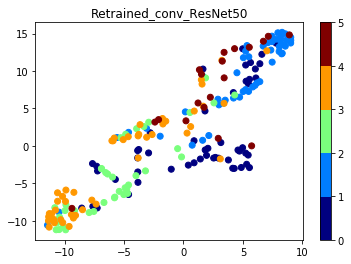

In [47]:
results_dir = join('..', '..', 'results')
plot_tSNE(feat_matrix_scaled, labels, title='Retrained_conv_ResNet50', path=results_dir)

## 2. Calculate features on the test data


This procedure is similar as for the training data, except that we do not know the labels and the folder with test images is not subdivided by material

In [ ]:
def calculate_features_test(test_dir):
    
    # Initialize a dataframe for the features    
    columns = ['id', 'features']
    df_features = pd.DataFrame(columns=columns)

    # Walk through all images
    for root, dirs, files in os.walk(test_dir):
        for file in files:
            img_fp = join(root, file)
            id = file.split('.')[0]
            print("Calculate features for", id)

            # Pad if size is too small, preprocess
            img = image.load_img(img_fp, target_size=(224, 224))
            img_data = image.img_to_array(img)
            img_data = np.expand_dims(img_data, axis=0)
            img_data = preprocess_input(img_data)

            # Compute features 
            features = model3.predict(img_data)
            features_np = np.array(features).flatten()

            df_features = df_features.append({'id': id ,
                                              'features': features_np},
                                             ignore_index=True)

    return df_features

In [ ]:
features_test = calculate_features_test(test_dir)

In [ ]:
features_test.head()

In [ ]:
import pickle
pickle_path = join('..', '..', 'pickles')
with open(join(pickle_path, 'resnet50_avg_retrained_features_' + region + '_test.pkl' ), 'wb') as f:
    pickle.dump(features_test, f)